Benaissa-Lejay Ilian et Paquin Enguerrand


# Introduction

Le calcul des superpixels d'une image est une étape antérieure aux tâches de classification et de segmentation d'image. En effet, ce pré-calcul des superpixels permet de calculer efficacement la segmentation d'image et de rendre celle-ci plus robuste.

Les superpixels sont des composantes connexes de pixels homogènes répartis régulièrement sur l'image et l'ensemble des superpixels forme une partition. De plus, les bordures des superpixels doivent suivre les contours de l'image le plus fidèlement possible

L'article propose une méthode de calcul de ces superpixels rivalisant avec l'état de l'art et avec une complexité en la taille de l'image.

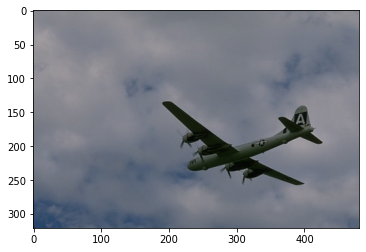

In [5]:
import numpy as np
import scipy
from scipy import ndimage
import skimage
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import cv2
import math
import pickle
import tqdm

img_path = 'BSR/BSDS500/data/images/val/3096.jpg'
im = Image.open(img_path)
np_img = np.array(im)
plt.imshow(np_img, cmap='gray')
plt.show()

# Description de l'algorithme

## Calcul du gradient de l'image

On commence par appliquer un filtre gaussien sur l'image pour éliminer les détails trop fins de l'image, cela améliore le résultat du gradient morphologique.

On calcule le gradient morphologique de l'image avec un carré 3x3 comme élément structurant à partir de la composante de clarté (L) de l'espace chromatique LAB. Cet espace répartit les couleurs conformément à la perception des écarts de couleur par le système visuel humain.


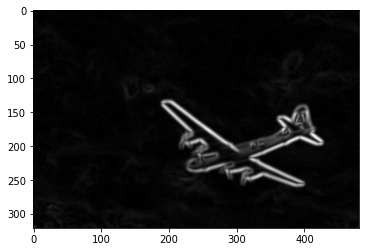

In [6]:
def morphological_grad(img, k_val=3, gauss_sigma=2):
    if img.ndim >= 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,0]
    img = ndimage.gaussian_filter(img,gauss_sigma)
    grad = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, np.ones((k_val, k_val)))
    grad = grad / grad.max()
    return grad
g_img = np.array(morphological_grad(np_img))
plt.imshow(g_img, cmap='gray')
plt.show()

## Définition d'une grille hexagonale de cellules

Cette grille permet d'assurer la régularité des superpixels. Le but est de calculer un superpixel par cellule.

## Sélection des marqueurs

Dans chaque cellule hexagonale, on sélectionne les pixels égaux au minimum local du gradient de l'image. On sélectionne ensuite la composante connexe de plus grande surface comme marqueur de la cellule.

On a décidé de créer une classe cellule pour calculer ces marqueurs. Nous utilisons la fonction connectedComponentsWithStats d'OpenCV pour sélectionner la composante connexe de plus grande surface.  

In [7]:
class Cell():
    def __init__(self,x,y,r,rho,img):
        if img.max() <= 1:
            img = (img*255).astype(np.uint8)
        self.img = img
        self.center = (x,y)
        self.corner = (
            self.constrain(int(y-r),0,self.img.shape[0]-1),
            self.constrain(int(x-r*np.sqrt(3)/2),0,self.img.shape[1]-1),
            self.constrain(int(y+r),0,self.img.shape[0]-1),
            self.constrain(int(x+r*np.sqrt(3)/2),0,self.img.shape[1]-1))
        self.rad = r
        self.rho = rho
        self.values, self.mask = self.get_values()
        self.marker = self.get_marker()
        
    
    def constrain(self,val,min_val, max_val):
        return max(min_val, min(val,max_val))    

    def get_center(self):
        return (self.constrain(int(self.center[1]),0,self.img.shape[0]-1), self.constrain(int(self.center[0]),0,self.img.shape[1]-1))

    def get_values(self):
        msk = Image.new("L", (self.img.shape[1] + 2*self.rad, self.img.shape[0] + 2*self.rad))
        msk_d = ImageDraw.Draw(msk)
        poly = [(self.rad + self.center[0] + math.cos(th) * self.rad * self.rho, 
                 self.rad + self.center[1] + math.sin(th) * self.rad * self.rho) 
                 for th in [math.pi/6 + i * 2 * math.pi / 6 for i in range(6)]]
        msk_d.polygon(poly, fill=1)
        msk = np.array(msk, dtype=np.uint8)
        msk = msk[self.rad:-self.rad, self.rad:-self.rad]
        values = self.img * msk
        return values, msk
    
    def get_marker(self):
        marker = np.zeros(self.img.shape, dtype=np.uint8)
        crop_img = self.img[self.corner[0]:self.corner[2], self.corner[1]:self.corner[3]]
        crop_mask = self.mask[self.corner[0]:self.corner[2], self.corner[1]:self.corner[3]]
        minima_img = np.zeros(crop_img.shape, dtype=np.uint8)
        minima_img[np.where(crop_img == crop_img.min())] = 1
        minima_crop = minima_img * crop_mask
        (totalLabels, label_ids, stats, _) = cv2.connectedComponentsWithStats(minima_crop)
        idx, max_area = 0, 0.0
        for j in range(1,totalLabels):
            area = stats[j, cv2.CC_STAT_AREA]
            if area > max_area:
                idx = j
                max_area = area
        if idx == 0:
            marker[self.constrain(int(self.center[1]),0,self.img.shape[0]-1), self.constrain(int(self.center[0]),0,self.img.shape[1]-1)] = 1
        else:
            indexes = np.where(label_ids==idx)
            marker[(indexes[0] + self.corner[0], indexes[1] + self.corner[1])] = 1
        return marker

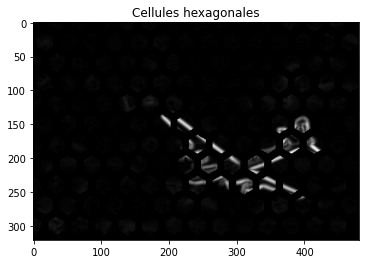

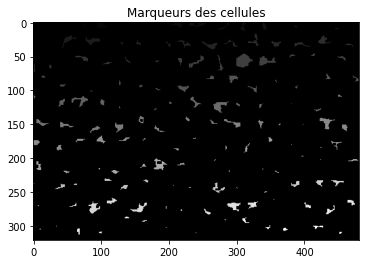

In [8]:
def compute_cells(img, radius=20, rho=2/3):
    H,W = img.shape
    cells = []
    hex_wid = radius * np.sqrt(3)
    hex_hei = radius * 1.5
    for i in range(int(H/hex_hei)+1):
        for j in range(int(W/hex_wid)+1):
            center = (i*hex_hei, j*hex_wid) if i%2==0 else (i*hex_hei, j*hex_wid+hex_wid/2)
            cells.append(Cell(center[1], center[0], radius, rho, img))
    return cells

def get_glob_marker_distinct(cells):
    glob_marker_distinct = np.zeros(cells[0].img.shape, dtype=np.uint16)
    for i,cell in enumerate(cells):
        glob_marker_distinct += cell.marker * (i+1)
    return glob_marker_distinct

cells = compute_cells(g_img)
all_cells_img = np.zeros_like(cells[0].values)
for cell in cells:
    all_cells_img += cell.values
glob_marker_distinct = get_glob_marker_distinct(cells)

plt.title("Cellules hexagonales")
plt.imshow(all_cells_img, cmap='gray')
plt.show()
plt.title("Marqueurs des cellules")
plt.imshow(glob_marker_distinct, cmap='gray')
plt.show()

## Calcul d'une carte des distances aux marqueurs

On utilise l'algorithme de Danielsson-Leymarie pour calculer en temps linéaire une très bonne approximation de la transformée en distance euclidienne sur une maille carrée.

On obtient une matrice des distances euclidiennes de chaque point à son marqueur le plus proche.

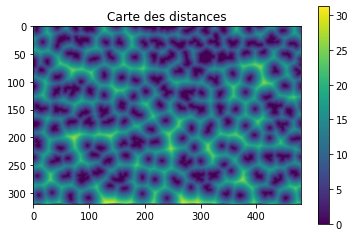

In [24]:

def DF(a,b,i,j,dist_map):
    return 2*abs(a*dist_map[i+a,j+b,1]) + 2*abs(b*dist_map[i+a,j+b,2]) + a**2 + b**2

def DL_distance_map(markers):
    W,H = markers.shape
    dist_map = np.zeros((W,H,3))
    for i in range(W):
        for j in range(H):
            if markers[i,j] != 0:
                dist_map[i,j] = np.array([0,0,0])
            else:
                dist_map[i,j] = np.array([np.inf,0,0])

    V_minus = [(-1,-1),(-1,0),(-1,1),(0,-1)]
    for i in range(1,W):
        for j in range(1,H-1):
            if markers[i,j] != 0:
                continue
            a,b = min((dist_map[i+elt[0],j+elt[1],0] + DF(elt[0],elt[1],i,j,dist_map), elt) for elt in V_minus)[1]
            dist_map[i,j,1], dist_map[i,j,2] = dist_map[i+a,j+b,1]+a, dist_map[i+a,j+b,2]+b
            dist_map[i,j,0] = dist_map[i+a,j+b,0] + DF(a,b,i,j,dist_map)

    V_plus = [(1,1),(1,0),(1,-1),(0,1),(0,0)]
    for i in range(W-2,-2,-1):
        for j in range(H-2,-2,-1):
            if markers[i,j] != 0:
                continue
            a,b = min((dist_map[i+elt[0],j+elt[1],0] + DF(elt[0],elt[1],i,j,dist_map), elt) for elt in V_plus)[1]
            dist_map[i,j,1], dist_map[i,j,2] = dist_map[i+a,j+b,1]+a, dist_map[i+a,j+b,2]+b
            dist_map[i,j,0] = dist_map[i+a,j+b,0] + DF(a,b,i,j,dist_map)

    return np.sqrt(dist_map[:,:,0])

m_dist_map = DL_distance_map(glob_marker_distinct)
plt.title("Carte des distances")
plt.imshow(m_dist_map)
plt.colorbar()
plt.show()

## Calcul du gradient spatialement régularisé

Cette carte des distances permet de calculer un gradient spatialement régularisé : 
$$ g_{reg} = g + kd_Q $$
où $g$ est le gradient de l'image, $d_Q$ la carte des distances et $k$ le paramètre de régularisation spatiale.

Le but du calcul de ce gradient spatialement régularisé et d'assurer la régularité des superpixels calculés grâce à l'algorithme de watershed qu'on verra ensuite.

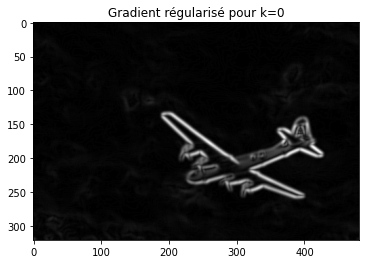

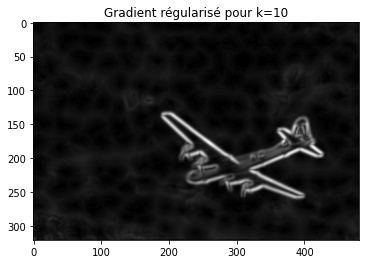

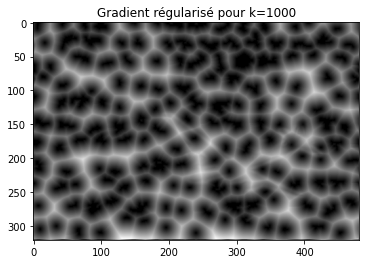

In [10]:
def compute_reg_grad(g_img, dist_map, k=10, cell_dist=20):
    return g_img + k * (2/cell_dist) * dist_map

reg_g_img_k0 = compute_reg_grad(g_img*255, m_dist_map, k=0)
reg_g_img_k10 = compute_reg_grad(g_img*255, m_dist_map, k=10)
reg_g_img_k100 = compute_reg_grad(g_img*255, m_dist_map, k=1000)

plt.title("Gradient régularisé pour k=0")
plt.imshow(reg_g_img_k0, cmap='gray')
plt.show()
plt.title("Gradient régularisé pour k=10")
plt.imshow(reg_g_img_k10, cmap='gray')
plt.show()
plt.title("Gradient régularisé pour k=1000")
plt.imshow(reg_g_img_k100, cmap='gray')
plt.show()

On remarque que pour $k=0$ le gradient spatialement régularisé est égal au gradient.  
Pour $k>>1$, le gradient spatialement régularisé tend vers la carte des distances, le gradient de l'image devient négligeable. 

## Application de l'algorithme de watershed

On applique l'algorithme de watershed sur le gradient spatialement régularisé en prenant comme bassins initiaux les marqueurs de chaque cellule. Les frontières entre les différents bassins à la fin de l'algorithme de watershed constituent les contours des superpixels.

Ces superpixels obtenus sont appelés waterpixels par les auteurs de l'article.

(On utilise l'algorithme de watershed de la librairie skimage.segmentation)

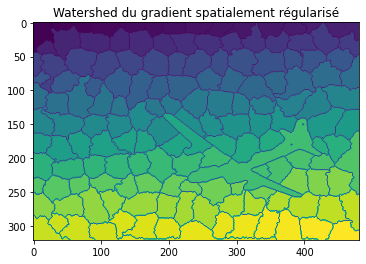

In [11]:
labels = skimage.segmentation.watershed(reg_g_img_k10, glob_marker_distinct, watershed_line=True)
plt.title("Watershed du gradient spatialement régularisé")
plt.imshow(labels)
plt.show()

Il suffit de garder les frontières entre les bassins pour afficher les waterpixels.

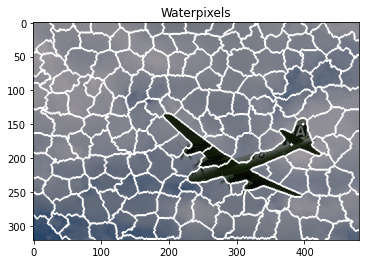

In [12]:
def compute_segmentation(img, labels):
    waterpix_mask = (labels == 0) * 255
    if img.ndim >= 3:
        waterpix_mask = np.tile(np.expand_dims(waterpix_mask, axis=-1),3)
    waterpix_mask = skimage.morphology.dilation(waterpix_mask)
    return np.where(waterpix_mask, waterpix_mask, img)

def compute_segmentation_only_mask(labels):
    waterpix_mask = (labels == 0)
    waterpix_mask = waterpix_mask.astype(np.uint8)
    return waterpix_mask

plt.title("Waterpixels")
plt.imshow(compute_segmentation(np_img, labels))
plt.show()

On résume enfin toutes les étapes dans une unique fonction.

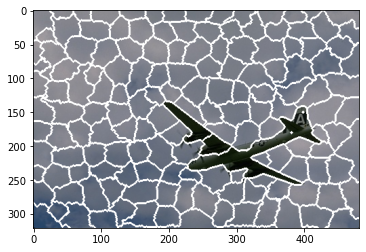

In [13]:
def waterpixel(img, cell_rad, k, rho, only_labels=False, only_mask=False):
    g_img = morphological_grad(img)
    cells = compute_cells(g_img, radius=cell_rad, rho=rho)
    glob_marker_distinct = get_glob_marker_distinct(cells)

    dist_map = DL_distance_map(glob_marker_distinct)

    reg_g_img = compute_reg_grad(g_img*255, dist_map, k, cell_dist=cell_rad)

    labels = skimage.segmentation.watershed(reg_g_img, glob_marker_distinct, watershed_line=True)
    
    if only_labels:
        return labels
    
    if only_mask:
        waterpix_img = compute_segmentation_only_mask(labels)
    else :
        waterpix_img = compute_segmentation(img,labels)
    return waterpix_img

wat_img = waterpixel(np_img, 20, 10, 2/3)
plt.imshow(wat_img)
plt.show()

wat_labels = waterpixel(np_img, 20, 10, 2/3, only_labels=True)
wat_border = compute_segmentation_only_mask(wat_labels)

# Evaluation

Il est maintenant nécessaire d'évaluer la méthode et de la comparer à l'état de l'art.

## Densité de contour

Elle est définie par le nombre de pixels appartenants aux contours des superpixels divisé par la nombre de pixels total de l'image.

$$CD = \frac{|S_c|}{|D|}$$

De bons superpixels doivent avoir une densité de contour faible.


In [14]:
def contourDensity(border):
    w,h=border.shape[:2]
    sb = 2*(w+h)-4
    sc = border.sum()
    d = w*h
    return (sc+sb)/d

print("Densité de contour : {}".format(contourDensity(wat_border)))

Densité de contour : 0.06855525547114333


## Facteur de discordance

Pour deux ensembles $A$ et $B$, on définit le facteur de discordance : 
$$ mf(A,B) = 1 - \frac{|A \cap B|}{|A \cup B|} $$
On a alors le facteur de discordance en moyenne suivant : 
$$ MF = \frac 1 N \sum_{i=1}^N mf(s_i^*, \hat s^*) $$
où $s_i^*$ est le superpixel $i$ centré et $\hat s^*$ est la moyenne des superpixels centrés.

Ce facteur permet de mesurer la régularité des superpixels. Plus MF est petit et plus les superpixels sont réguliers

In [15]:
def barycenters(labels):
    indiceMax = labels.max()
    barys = []
    for idx in range(1,indiceMax+1):
        coordsx,coordsy = np.where(labels==idx)
        baryX = coordsx.sum() / len(coordsx)
        baryY = coordsy.sum() / len(coordsy)
        barys.append((int(baryX.round()),int((baryY.round()))))
    return barys

def average_superpix(labels, barys):
    w,h = labels.shape
    avg = np.zeros((2*w,2*h))
    indiceMax = labels.max()
    
    for idx in range(1,indiceMax+1):
        x,y = np.where(labels==idx)
        coordsX = x - barys[idx-1][0] + w
        coordsY = y - barys[idx-1][1] + h
        for i in range(len(x)):
            avg[coordsX[i],coordsY[i]] += 1
    avg = avg/indiceMax
    avg = avg>=0.5

    return avg

def centered_label(i, barys, labels):
    w,h = labels.shape
    result = np.zeros((2*w,2*h))
    x,y = np.where(labels==i)
    for j in range(len(x)):
        result[x[j]-barys[i-1][0]+w,y[j]-barys[i-1][1]+h] = 1
    return result

def mf(img1, img2):
    inter = np.logical_and(img1, img2).sum()
    union = np.logical_or(img1, img2).sum()
    return 1 - inter / union

def missmatchFactor(labels):
    barys = barycenters(labels)
    avg = average_superpix(labels, barys)
    N = labels.max()
    S = 0
    for i in range(N):
        S += mf(centered_label(i,barys,labels), avg)
    return S/N


print("Facteur de discordance : {}".format(missmatchFactor(wat_labels)))

Facteur de discordance : 0.35837975714074943


## Facteur de concordance des contours

Ce facteur permet d'évaluer la précision des contours générés. A partir d'une image segmentée à la main, on veut calculer le nombre de pixels de contour de waterpixels qui sont à moins de 3 pixels de distance d'un contour réel de l'image.
$$ BR = \frac{|\{p \in GT, d(p,C) < 3\}|}{|GT|} $$
où $GT$ est le "Ground Truth" : l'image segmentée à la main, $C$ sont les contours obtenus par la méthode des waterpixels et $d$ est la distance $L1$

On calcule une carte des distance $L1$ en temps linéaire par un algorithme à double balayage.

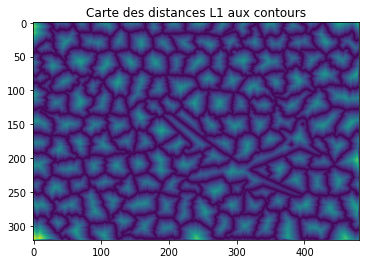

Facteur de concordance des contours : 0.753731343283582


In [16]:
gt_file = scipy.io.loadmat('BSR/BSDS500/data/groundTruth/val/3096.mat')
gt = np.array(gt_file['groundTruth'][0][0][0][0][1], dtype=np.float64)

def L1_distance_map(markers):
    W,H = markers.shape
    dist_map = np.zeros((W,H))

    for i in range(W):
        for j in range(H):
            if markers[i,j] == 0:
                dist_map[i,j] = np.inf

    V_minus = [(-1,0),(0,-1),(0,0)]
    V_plus = [(1,0),(0,1),(0,0)]
    for i in range(1,W):
        for j in range(1,H):
            if markers[i,j] != 0:
                continue
            dist_map[i,j] = min([dist_map[i+elt[0],j+elt[1]] + 1 for elt in V_minus])
    
    for i in range(W-2,-2,-1):
        for j in range(H-2,-2,-1):
            if markers[i,j] != 0:
                continue
            dist_map[i,j] = min([dist_map[i+elt[0],j+elt[1]] + 1 for elt in V_plus])

    return dist_map

d_map = L1_distance_map(wat_border)
plt.title("Carte des distances L1 aux contours")
plt.imshow(d_map)
plt.show()

def boundaryRecall(GT,wat_border):
    dist_map = L1_distance_map(wat_border)
    pos = np.where(GT == 1)
    S = np.sum(dist_map[pos] < 3)
    return S / np.sum(GT)

print("Facteur de concordance des contours : {}".format(boundaryRecall(gt, wat_border)))

## Comparaison avec SLIC

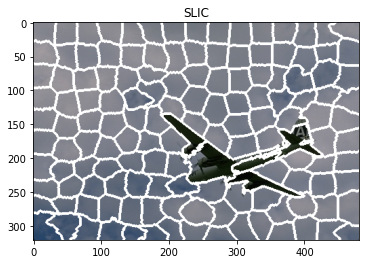

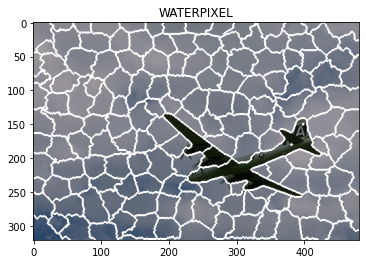

In [19]:
def get_n_seg(rad,width,height):
    return int((width / (rad * np.sqrt(3))) * (height / (rad * 1.5)))

h,w = np_img.shape[:2]

slic_labels = skimage.segmentation.slic(np_img, n_segments=get_n_seg(20,w,h))
slic_bounds = skimage.segmentation.find_boundaries(slic_labels)
slic_img = compute_segmentation(np_img, np.where(slic_bounds, np.zeros_like(slic_labels), slic_labels))

plt.title("SLIC")
plt.imshow(slic_img)
plt.show()

plt.title("WATERPIXEL")
plt.imshow(wat_img)
plt.show()

La cellule suivante calcule les valeurs de CD, MF et BR pour la méthode de waterpixels avec $k \in \{0,4,8,16\}$ et la taille des superpixels $r \in \{10,20,30,40\}$

On calcule de même CD, MF et BR pour la méthode SLIC avec $r \in \{10,20,30,40\}$

Ces facteurs sont calculés pour 20 images différentes puis moyennés

In [ ]:
folder = 'BSR/BSDS500/data/'
images = sorted([folder + 'images/val/' + elt for elt in os.listdir(folder + 'images/val/')])
gt_names = sorted([folder + 'groundTruth/val/' + elt for elt in os.listdir(folder + 'groundTruth/val')])

N_img = 20

k_values = [0,4,8,16]
rad_values = [10,20,30,40]

all_wat_results = np.zeros((4,4,3))
all_slic_results = np.zeros((4,3))

for img_name, gt_name in tqdm.tqdm(zip(images[:N_img],gt_names[:N_img])):
    print(img_name)
    img = np.array(Image.open(img_name))
    h,w = img.shape[:2]
    gt_file = scipy.io.loadmat(gt_name)
    gt = np.array(gt_file['groundTruth'][0][0][0][0][1], dtype=np.float64)

    for i, rad in enumerate(rad_values):
        for j, k in enumerate(k_values):
            wat_labels = waterpixel(img, rad, k, 2/3, only_labels=True)
            wat_border = compute_segmentation_only_mask(wat_labels)
            CD = contourDensity(wat_border)
            MF = missmatchFactor(wat_labels)
            BR = boundaryRecall(gt,wat_border)
            all_wat_results[i,j] += np.array([CD,MF,BR])
        
        slic_labels = skimage.segmentation.slic(img, n_segments=get_n_seg(rad,w,h))
        slic_bounds = skimage.segmentation.find_boundaries(slic_labels)
        CD = contourDensity(slic_bounds)
        MF = missmatchFactor(slic_labels)
        BR = boundaryRecall(gt,slic_bounds)
        all_slic_results[i] += np.array([CD,MF,BR])

results = {'wat': all_wat_results / N_img, 'slic': all_slic_results / N_img}
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

On affiche les résultats sous forme de graphique

On affiche dans un premier temps la valeur du facteur de la densité de contours en fonction de celle du facteur de concordance des contours.

On s'attend à ce que de bons superpixels aient une valeur élevée de concordance des contours pour une valeur plutôt faible de densité de contour. La méthode de waterpixel est un bon compromis entre ces deux objectifs. Elle a une plus faible densité de contour que SLIC pour une concordance des contours un peu plus faible que SLIC.

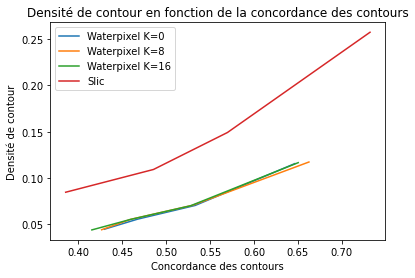

In [20]:
with open('results.pkl', 'rb') as f:
    res = pickle.load(f)
    res_wat = res['wat']
    res_slic = res['slic']

wat_k0_BR = res_wat[:,0,2]
wat_k8_BR = res_wat[:,2,2]
wat_k16_BR = res_wat[:,3,2]
slic_BR = res_slic[:,2]
wat_k0_CD = res_wat[:,0,0]
wat_k8_CD = res_wat[:,2,0]
wat_k16_CD = res_wat[:,3,0]
slic_CD = res_slic[:,0]
wat_k0_MF = res_wat[:,0,1]
wat_k8_MF = res_wat[:,2,1]
wat_k16_MF = res_wat[:,3,1]
slic_MF = res_slic[:,1]

plt.plot(wat_k0_BR, wat_k0_CD, label="Waterpixel K=0")
plt.plot(wat_k8_BR, wat_k8_CD, label="Waterpixel K=8")
plt.plot(wat_k16_BR, wat_k16_CD, label="Waterpixel K=16")
plt.plot(slic_BR, slic_CD, label="Slic")

plt.title("Densité de contour en fonction de la concordance des contours")
plt.xlabel("Concordance des contours")
plt.ylabel("Densité de contour")
plt.legend()
plt.show()


On peut voir grâce aux trois graphique suivants que la méthode des waterpixels à une densité de contours bien meilleure que SLIC. Son facteur de discordance est néanmoins un plus élevé que celui de SLIC. Cependant son facteur de concordance des contours est très proche de celui de SLIC.

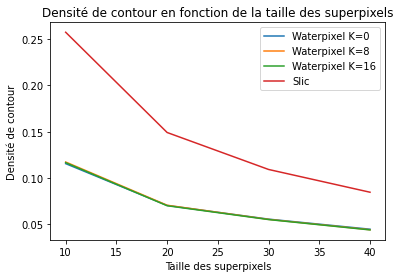

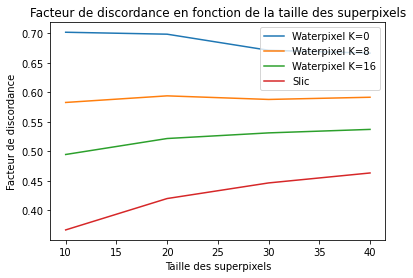

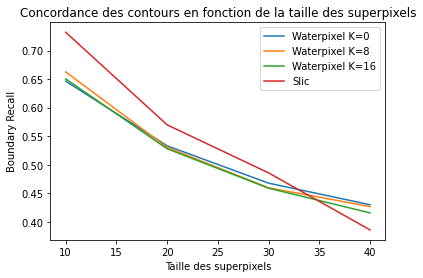

In [21]:
rad_values = [10,20,30,40]

plt.plot(rad_values, wat_k0_CD, label="Waterpixel K=0")
plt.plot(rad_values, wat_k8_CD, label="Waterpixel K=8")
plt.plot(rad_values, wat_k16_CD, label="Waterpixel K=16")
plt.plot(rad_values, slic_CD, label="Slic")

plt.title("Densité de contour en fonction de la taille des superpixels")
plt.xlabel("Taille des superpixels")
plt.ylabel("Densité de contour")
plt.legend()
plt.show()

plt.plot(rad_values, wat_k0_MF, label="Waterpixel K=0")
plt.plot(rad_values, wat_k8_MF, label="Waterpixel K=8")
plt.plot(rad_values, wat_k16_MF, label="Waterpixel K=16")
plt.plot(rad_values, slic_MF, label="Slic")

plt.title("Facteur de discordance en fonction de la taille des superpixels")
plt.xlabel("Taille des superpixels")
plt.ylabel("Facteur de discordance")
plt.legend()
plt.show()

plt.plot(rad_values, wat_k0_BR, label="Waterpixel K=0")
plt.plot(rad_values, wat_k8_BR, label="Waterpixel K=8")
plt.plot(rad_values, wat_k16_BR, label="Waterpixel K=16")
plt.plot(rad_values, slic_BR, label="Slic")

plt.title("Concordance des contours en fonction de la taille des superpixels")
plt.xlabel("Taille des superpixels")
plt.ylabel("Boundary Recall")
plt.legend()
plt.show()


Enfin, ce dernier graphique montre une lacune de la méthodes des waterpixels face à SLIC. SLIC est un meilleur compromis entre facteur de discordance et facteur de concordance des contours.

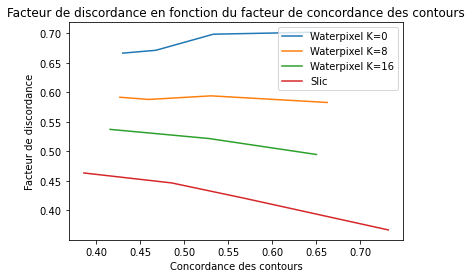

In [22]:

plt.plot(wat_k0_BR, wat_k0_MF, label="Waterpixel K=0")
plt.plot(wat_k8_BR, wat_k8_MF, label="Waterpixel K=8")
plt.plot(wat_k16_BR, wat_k16_MF, label="Waterpixel K=16")
plt.plot(slic_BR, slic_MF, label="Slic")

plt.title("Facteur de discordance en fonction du facteur de concordance des contours")
plt.xlabel("Concordance des contours")
plt.ylabel("Facteur de discordance")
plt.legend()
plt.show()

# Conclusion

Nous avons réimplémenter la méthode de calculs des waterpixels décrite dans l'article et nous l'avons évaluée en la comparant avec la méthode SLIC constituant l'état de l'art en matière de génération de superpixels.

Une attention toute particulière a été portée sur la complexité de la méthode de calcul des waterpixels, celle-ci est linéaire en le nombre de pixels de l'image.

Notre évaluation mène à la conclusion que cette méthode rivalise avec l'état de l'art, offrant une meilleure densité de contour que la méthode SLIC tout en ayant une concordance des contours presque égale. Cependant la régularité des superpixels, mesurée par le facteur de discordance, est moins bonne que pour la méthode SLIC.